In [15]:
import numpy as np
import pandas as pd

train_1=pd.read_csv(r"D:\Rohan\ML\Datasets\web-traffic-time-series-forecasting\train_1.csv")

In [16]:
train_1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [17]:
#extracting a stationary time series and a non-stationary time series
stationary_page_name=train_1["Page"][0]
stationary_page_row=train_1[train_1["Page"]==stationary_page_name]
stationary_time_series=stationary_page_row.drop(columns=["Page"])
stationary_time_series=stationary_time_series.values.flatten()

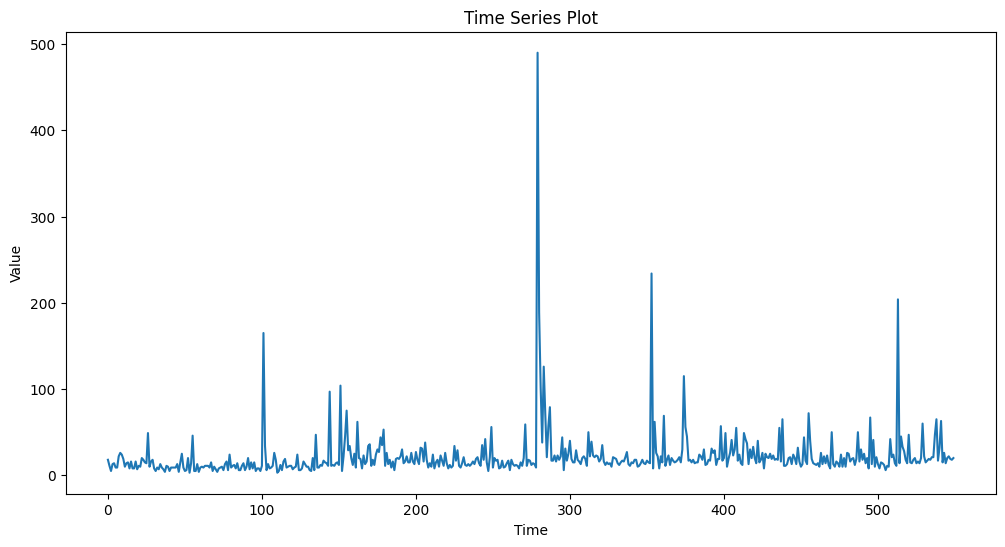

In [18]:
#time series with outliers
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(stationary_time_series)
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [19]:
#EDA
#detecting outliers using zscore method and removing them
mean = np.mean(stationary_time_series)
std_dev = np.std(stationary_time_series)
z_scores = [(y - mean) / std_dev for y in stationary_time_series]
outliers = np.where(np.abs(z_scores) > 3)

print(outliers)

(array([101, 279, 280, 283, 353, 374, 513], dtype=int64),)


In [20]:
stationary_time_series = np.delete(stationary_time_series, outliers)

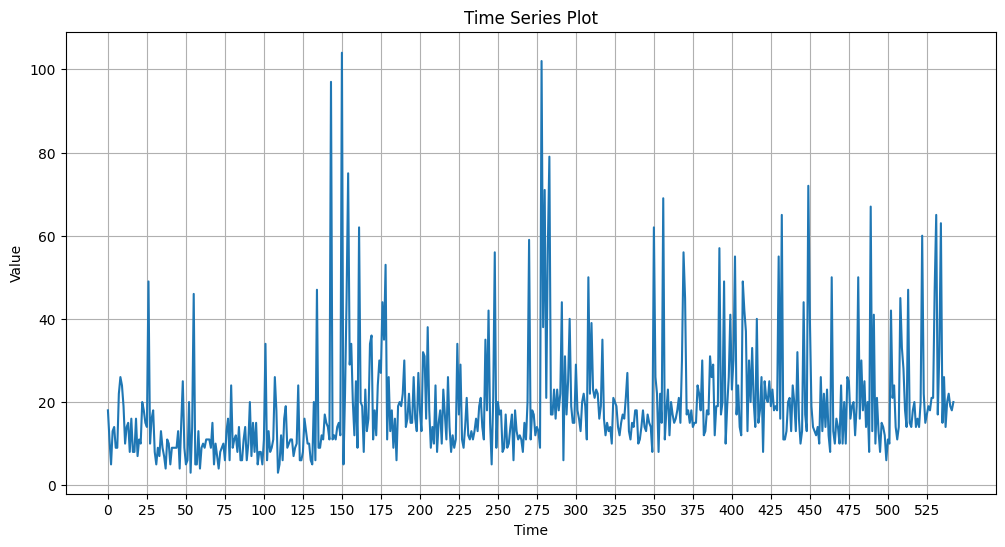

In [29]:
#time series without outliers
plt.figure(figsize=(12, 6))
plt.plot(stationary_time_series)
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')

plt.xticks(ticks=range(0, len(stationary_time_series), 25))
plt.grid(True)
plt.show()

In [70]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l2



time_series = np.array(stationary_time_series) #stationary_time_series is a list of website visits of 550 days

scaler = MinMaxScaler(feature_range=(0, 1)) #Normalization
time_series_scaled = scaler.fit_transform(time_series.reshape(-1, 1))
#The -1 means that the dimension is inferred automatically.
#Here, it means that the array will have as many rows as needed and exactly one column.

#shape of time_series_scaled will be (550,1)

#create_sequences creates sequences of 50 length each starting from index 0 and the target value is at index 51.
#These sequences are created, converted into numpy arrays and returned
def create_sequences(data, seq_length):
    xs = [] #list to store input sequences [[45,27,36], [91,12,21], .....]
    ys = [] #list to store target values   [87,14,39,......]
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50
X, y = create_sequences(time_series_scaled, SEQ_LENGTH)

#X.shape[0] is 493 and that is because 7 outliers were removed from 550 (543) and len(data)-seq_length = 493.
#There are 493 different sequences of 50 length each. Note: we can't create sequences whose website visits are randomly picked
#X.shape[1] is 50 because each sequence has length 50
X = X.reshape((X.shape[0], X.shape[1], 1)) #these 3 are dimensions
#1 indicates that 1 timestep has 1 feature value (website visits). If it had 2 feature values, then the 1 would have been 2
#X is a 3D array

#In the below model, 493 different sequences of 50 length each are inputted for training
model = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(25),
    Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X, y, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0227
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0179
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0186
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0194
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0191
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0201
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0154
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0215
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0171
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0166
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0222
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0174
Epoch 13/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0168
Epoch 14/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0185
Epoch 15/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - lo

In [24]:
X.shape[1]

50

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
RMSE: 13.245110241621854
MAE: 8.836758174470665
MAPE: 52.31921548226926


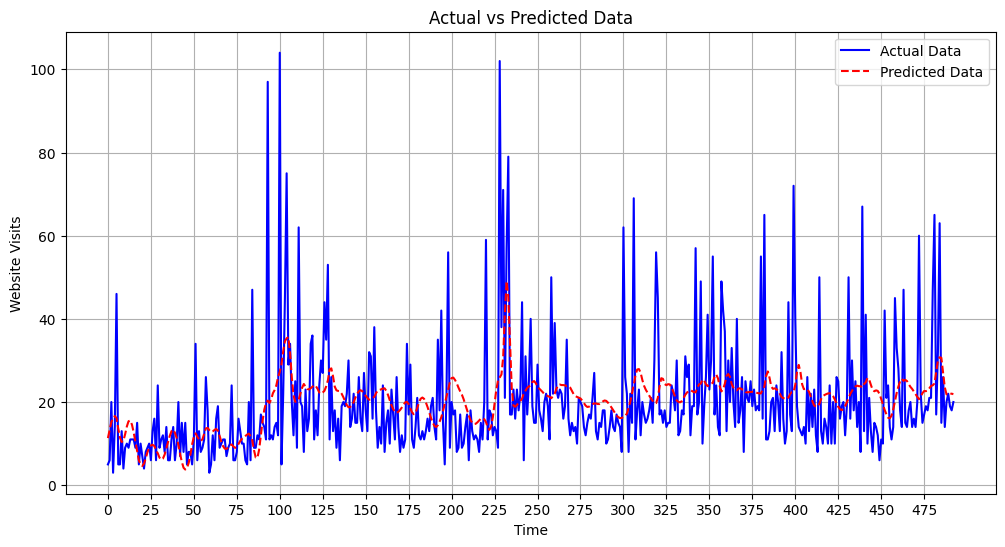

In [71]:
y_pred = model.predict(X)#predictions on every sequence in X


y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y.reshape(-1, 1)) #actual y values

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Data', color='blue')
plt.plot(y_pred, label='Predicted Data', color='red', linestyle='--')
plt.title('Actual vs Predicted Data')
plt.xlabel('Time')
plt.ylabel('Website Visits')
plt.xticks(ticks=range(0, len(y_true), 25))
plt.grid(True)
plt.legend()
plt.show()

# in the below graph, first 50 values as well as predictions of time series is not included

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

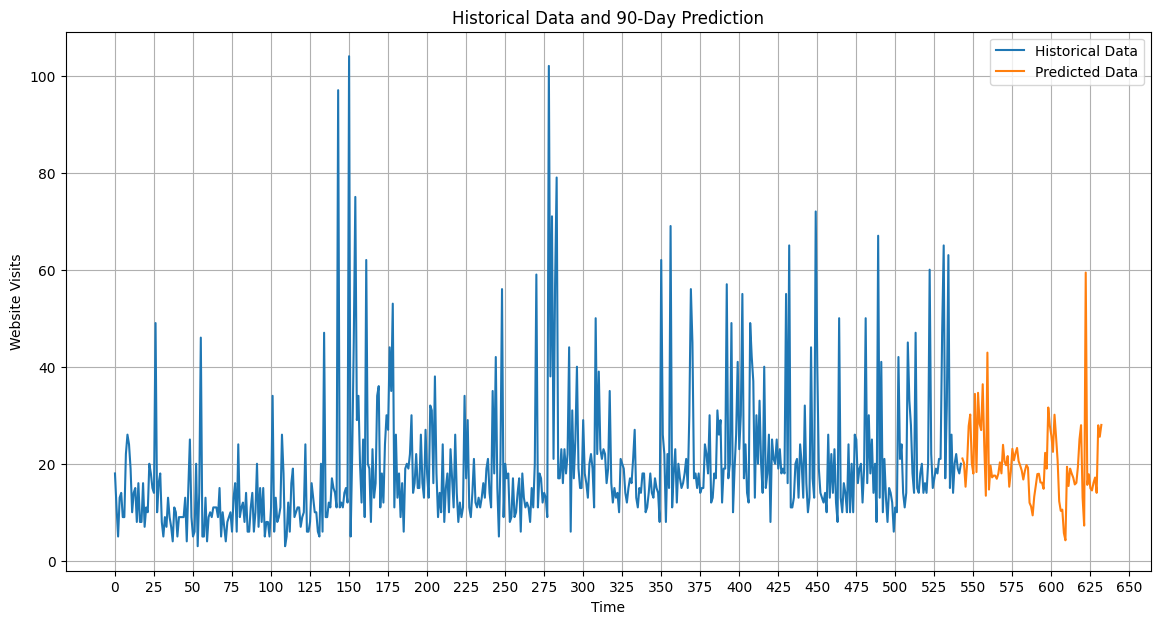

In [46]:
time_series = np.array(stationary_time_series)

scaler = MinMaxScaler(feature_range=(0, 1))
time_series_scaled = scaler.fit_transform(time_series.reshape(-1, 1))

n_predictions = 90
SEQ_LENGTH=50
last_sequence = time_series_scaled[-SEQ_LENGTH:]

predictions = []
temp_sequence = last_sequence.copy().reshape(1, -1, 1)
for _ in range(n_predictions):
    pred = model.predict(temp_sequence)
    predictions.append(pred[0][0])
    temp_sequence = np.append(temp_sequence[:, 1:, :], pred.reshape(1, 1, 1), axis=1)
    # so the next set of 50 values is taken into consideration which includes the old 49 values + the previous prediction

predictions = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(14, 7))
plt.plot(range(len(time_series)), time_series, label='Historical Data')
plt.plot(range(len(time_series), len(time_series) + n_predictions), predictions, label='Predicted Data')
plt.xlabel('Time')
plt.ylabel('Website Visits')
plt.title('Historical Data and 90-Day Prediction')
plt.xticks(ticks=range(0, len(time_series) + n_predictions+25, 25))
plt.grid(True)
plt.legend()
plt.show()

#543 values in stationary_time_series + 90 predictions are shown below

In [ ]:
# add a pipeline to this code which preprocess data automatically




When training the LSTM model for 50 epochs,from epoch 12 to epoch 50, mean_squared_error (loss) goes to 0.02 and keeps fluctuating
there. The model underfits.

If I train for a higher number of epochs (750,1000 etc) then the model starts memorising the pattern

kernel regularizer l2 is not working with this lstm (model is not able to learn the pattern and a straight line is being outputted
as the prediction)

Therefore, the LSTM model is not working

